In [1]:
import random
import librosa
import librosa.display
import scipy
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import IPython.display as ipd
import cv2
import soundfile as sf





# import torch
# import torchaudio
# from torchaudio import transforms
%matplotlib inline

In [76]:
def fourier_db(stft):
    fourier_abs = np.abs(stft)
    dB = 20 * np.log10(fourier_abs / np.max(fourier_abs))
    return dB

def noise_in_freq_range(stft, low_freq, high_freq, noise_level_dB):#, band_pass = False):
    # stft = librosa.stft(audio, n_fft=1024, hop_length=256)
    stft_mag, stft_phase = librosa.magphase(stft)

    # Find the indices of the frequency bins that lie within the desired range
    freq_bins = np.where((fft_freqs >= low_freq) & (fft_freqs <= high_freq))[0]

    # Convert noise level from dB to linear scale
    noise_level_linear = 10**(noise_level_dB / 20.0)

    # Apply noise to the magnitude of the specified frequency bins
    noise = np.random.randn(*stft_mag.shape) * noise_level_linear
    
    stft_mag[freq_bins, :] += noise[freq_bins, :]
    
    # if band_pass == False:
    #     # operator += adds noise to the original values of D_mag
    #     D_mag[freq_bins, :] += noise[freq_bins, :]
    # 
    # else:
    #     # operator = replaces the values, cutting of the frequencies in freq_bins, as a sort of band_pass filter
    #     D_mag[freq_bins, :] = noise[freq_bins, :]

    # Combine the modified magnitude with the original phase
    D_noisy = stft_mag * stft_phase

    # Perform the inverse STFT to convert back to the time domain
    audio_noise = librosa.istft(D_noisy)

    return audio_noise

def plot_spectrogam(hop_length, file):
    plt.figure(figsize=(8, 4))
    D = librosa.amplitude_to_db (np.abs (librosa.stft (file, hop_length=hop_length)),
                                 ref=np.max)
    librosa.display.specshow (D, y_axis='log', sr=sr, hop_length=hop_length,
                              x_axis='time')
    plt.title ('Log-frequency power spectrogram')

def plot_mel_spectrogam(file, title):
    plt.figure(figsize=(8, 4))
    S = librosa.feature.melspectrogram(y=file, sr=sr, n_mels=128,

                                    fmax=8000)
    fig, ax = plt.subplots()
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr,
                             fmax=11025, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title=title)

def plot_fourier(signal, fft_freqs, fill_area=None, fill=False):
    plt.figure(figsize=(8, 4))
    plt.plot(fft_freqs[:300], signal.T[10][:300])
    
    if fill and fill_area is not None:
        # Fill the gray area
        plt.fill_between(fill_area, plt.ylim()[0], plt.ylim()[1], color='gray', alpha=0.5)
        if fill_area[0] > 1000:
            plt.xlim(fill_area[0]-1000, fill_area[1]+1000)
        else:
            plt.xlim(fill_area[0]-500, fill_area[1]+500)
    
    plt.xticks(fill_area)
    plt.ylim(-80,0)
    # plt.yscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (dB)')
    plt.show()
    plt.close()

def plot_compare(original_audio, modified_audio):
    plt.figure (figsize=(8, 6))
    plt.subplot (2, 1, 1)
    librosa.display.specshow (librosa.amplitude_to_db (np.abs (librosa.stft (original_audio)), ref=np.max),
                              sr=sr, y_axis='log', x_axis='time')
    plt.title ('Original Spectrogram')
    plt.colorbar (format='%+2.0f dB')
    plt.subplot (2, 1, 2)
    librosa.display.specshow (librosa.amplitude_to_db (np.abs (librosa.stft (modified_audio)), ref=np.max),
                              sr=sr, y_axis='log', x_axis='time')
    plt.title ('Noisy Spectrogram')
    plt.colorbar (format='%+2.0f dB')
    plt.tight_layout ()
    plt.show ()

In [81]:
redhot = fr"C:\Users\LEGION\PycharmProjects\AudioDataAugmentation\redhot.wav"
title = redhot.split('''\\''')[-1]
print(title)
    # def laplace_extraction(self, file):
    #     """
    #     Extracts Laplace value from the filename based on a defined format.
    # 
    #     Args:
    #         file (str): Path to the signal file.
    # 
    #     Returns:
    #         list: List containing the extracted Laplace value (float).
    #     """
    #     file = str (file)
    #     parts = file.split ('_')
    #     laplace_value = []
    #     if len (parts) >= 5:
    #         # Adjust the index based on your file name structure
    #         desired_part = parts[3] #.split ('.')
    #     laplace_value.append (desired_part)
    #     laplace_value = [int (value.replace (',', '.')) for value in laplace_value]
    #     return laplace_value
    

redhot.wav


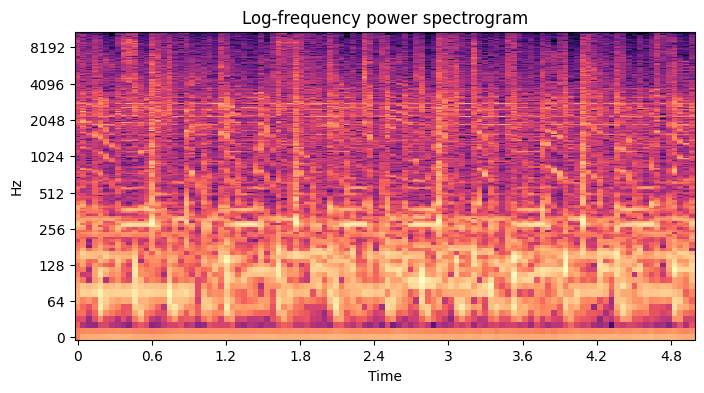

<Figure size 800x400 with 0 Axes>

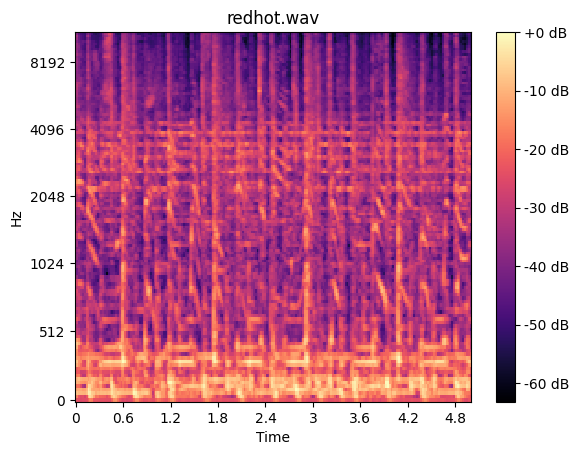

In [82]:
# Load file and perform STFT
redhot = fr"C:\Users\LEGION\PycharmProjects\AudioDataAugmentation\redhot.wav"
title = redhot.split('''\\''')[-1]
redhot_file, sr = librosa.load(redhot, duration=5, mono=False, sr=22050)

n_fft = 1024
stft = librosa.stft(redhot_file, n_fft=n_fft)
fft_freqs = np.round(librosa.fft_frequencies(sr=sr, n_fft=n_fft))

# play file
ipd.Audio(redhot_file, rate=sr)
plot_spectrogam(hop_length=1024, file=redhot_file)
plot_mel_spectrogam(file=redhot_file, title=title)

time shift:  -21195


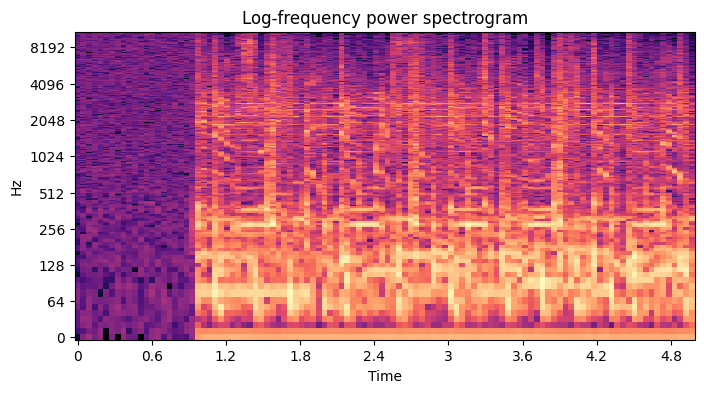

In [27]:
# time shift - introduces noise to change the start point of file
start_ = int(np.random.uniform(-30000,30000))
print('time shift: ',start_)
if start_ >= 0:
    wav_time_shift = np.r_[redhot_file[start_:], np.random.uniform(-0.01,0.01, start_)]
else:
    wav_time_shift = np.r_[np.random.uniform(-0.01,0.01, -start_), redhot_file[:start_]]

plot_spectrogam(hop_length=1024, file=wav_time_shift)
ipd.Audio(wav_time_shift, rate=sr)

In [10]:
# changing the speed rate and the pitch (proportionally)

rng = np.random.default_rng()
speed_rate = rng.uniform(low=0.7, high=1.3)

wav_speed_tune = cv2.resize(redhot_file, (1, int(len(redhot_file) * speed_rate))).squeeze()
print('speed rate: %.3f' % speed_rate, '(lower is faster)')
if len(wav_speed_tune) < len(redhot_file):
    pad_len = len(redhot_file) - len(wav_speed_tune)
    wav_speed_tune = np.r_[rng.uniform(-0.001,0.001,int(pad_len/2)),wav_speed_tune,rng.uniform(-0.001,0.001,int(np.ceil(pad_len/2)))]
else: 
    cut_len = len(wav_speed_tune) - len(redhot_file)
    wav_speed_tune = wav_speed_tune[int(cut_len/2):int(cut_len/2)+1223424]
print('wav length: ', wav_speed_tune.shape[0])
ipd.Audio(wav_speed_tune, rate=sr)

speed rate: 1.177 (lower is faster)
wav length:  120001


In [11]:
# changing length without changing pitch (time stretch)

time_stretch = librosa.effects.time_stretch(y=redhot_file, rate=1.2)
ipd.Audio(time_stretch, rate=sr)

In [46]:
# Psychoacoustic frequency filters
f0 = 27.5
cents = range(0,11500,300) # Until 19KHz 300 cents = minor 3rd filters
fil_freq = np.round([f0*(pow((2**((1.0/1200))),i)) for i in cents])
print(len(fil_freq))

39


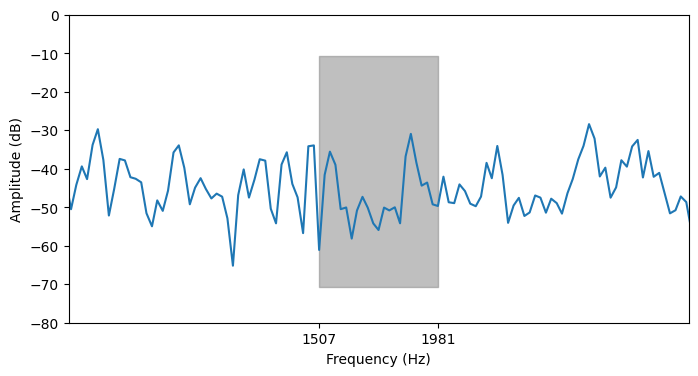

In [44]:
# Define FR
low_freq = 1500  # Lower lim of FR
high_freq = 2000  # Upper lim of FR
freq_bins = np.where((fft_freqs >= low_freq) & (fft_freqs <= high_freq))[0]
noise_level_dB = 30  # Noise level in dB

# Plot FR
redhot_db = fourier_db(stft)
gray_area_x = [fft_freqs[freq_bins[0]], fft_freqs[freq_bins[-1]]]
plot_fourier(signal=redhot_db, fft_freqs=fft_freqs, fill_area=gray_area_x, fill=True)


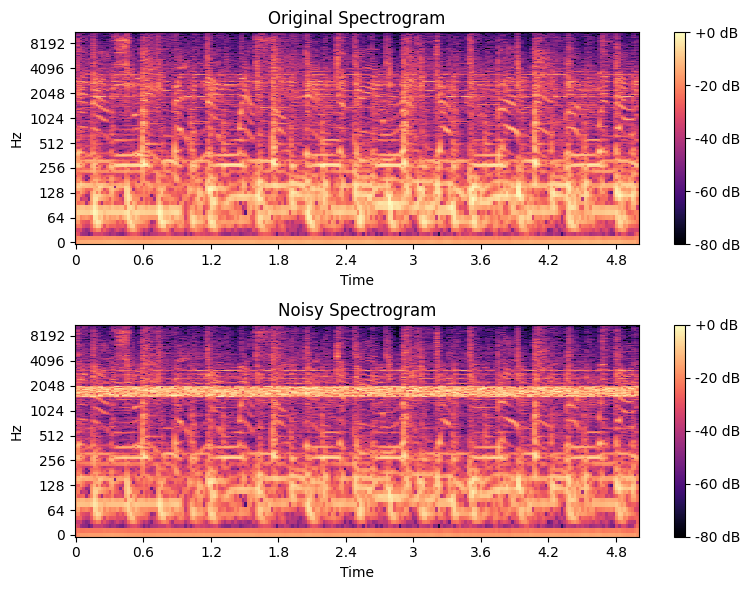

In [25]:
# add noise within the FR
audio_noisy = noise_in_freq_range(stft, low_freq, high_freq, noise_level_dB)

# Save the modified audio to a new file
output_filename = 'output_noisy.wav'
sf.write(output_filename, audio_noisy, sr)

plot_compare(redhot_file, audio_noisy)


<Figure size 800x400 with 0 Axes>

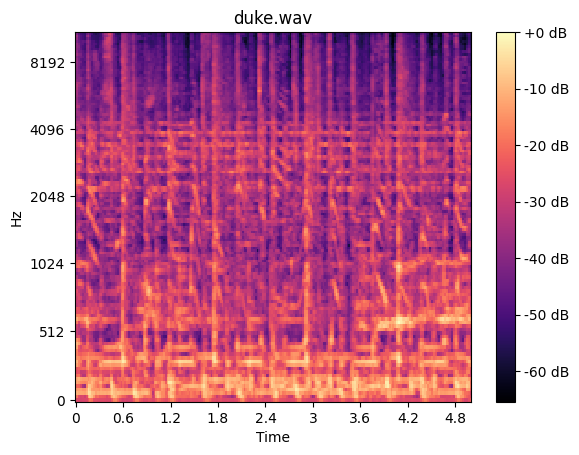

In [83]:
# MixUp technique Inoue(2018)

# Define FR to be patched
low_freq = 512
high_freq = 1024
noise_level_dB = 6
freq_bins = np.where((fft_freqs >= low_freq) & (fft_freqs <= high_freq))[0]

# Extract audio patch
patch = fr'C:\Users\LEGION\PycharmProjects\AudioDataAugmentation\duke.wav'
title2 = patch.split('''\\''')[-1]
patch_file, sr = librosa.load(patch, duration=5, mono=False, sr=22050)
patch_stft = librosa.stft(patch_file, n_fft=1024)
stft_mag_patch, stft_phase_patch = librosa.magphase(patch_stft)
stft_mag_orig, stft_phase_orig = librosa.magphase(stft)

# Apply patch
noise_level_linear = 10**(noise_level_dB / 20.0)
patch_db = stft_mag_patch * noise_level_linear
stft_mag_orig[freq_bins, :] += patch_db[freq_bins, :]
mix_up = stft_mag_orig * stft_phase_orig
audio_noise = librosa.istft(mix_up)

# Save new audio
output_filename = 'output_noisy.wav'
sf.write(output_filename, audio_noise, sr)
ipd.Audio(audio_noise, rate=sr)

plot_mel_spectrogam(audio_noise, title2)

In [92]:
# stft_mag_patch, stft_phase_patch = librosa.magphase(patch_stft)
print(stft_mag_orig[200])
new_orig = stft_mag_orig[200] = stft_mag_patch[200]
# print(new_orig)

[4.08158511e-01 8.08619678e-01 8.84107053e-01 7.43587911e-01
 6.20603025e-01 4.89233136e-01 2.97147930e-01 1.10271782e-01
 1.70079231e-01 1.25120997e-01 2.31829677e-02 5.64061962e-02
 1.16323315e-01 2.04437762e-01 1.74477950e-01 7.67537504e-02
 1.20068088e-01 9.76456255e-02 4.08150479e-02 7.81116262e-02
 7.52264187e-02 4.38022316e-02 5.95067516e-02 1.48070589e-01
 1.75796300e-01 9.89017934e-02 1.10606305e-01 9.04247314e-02
 6.10870086e-02 5.71837425e-02 1.58990353e-01 2.58494556e-01
 1.78197131e-01 1.18637390e-01 1.06275983e-01 8.80031064e-02
 5.71793728e-02 5.62368557e-02 4.08280343e-02 1.44344624e-02
 8.06155335e-03 1.04456842e-02 1.11812484e-02 1.79206748e-02
 4.92681516e-03 7.86322914e-03 5.69022261e-03 1.28716333e-02
 2.90100276e-03 1.71995517e-02 2.36719083e-02 5.39633865e-03
 2.76830187e-03 9.23176948e-03 9.19090211e-03 5.48304431e-03
 7.14940298e-03 2.54011876e-03 6.54318370e-03 1.14885168e-02
 1.80609040e-02 9.85001959e-03 1.12113319e-02 2.65115295e-02
 2.29736660e-02 2.691171